# Interpretability of a logistic regression model

Interpret means to "explain" or to present in understandable terms. The ability to express in understandable terms, what the 
model has learned and the reasons that affect their output.

Interpretability is about the extent to which a cause and effect can be observed within a system. Or to put it another way, it is the extent to which you are able to predict what is going to happen, given a change in input or algorithmic parameters. It's being able to understand which inputs are the most predictive (i.e., impact the prediction/output the most), and anticipate how predictions will change with differing inputs.

* If a customer is rejected a loan, we can say why
* If an insurance provides a certain premium, we know the reasons.
* If we diagnose a patient with a certain disease, we can tell them why

## Fit a logistic regression model and make global and local explanations

Predict whether a student will dropout from their class.

The workflow is the following:

- Exploratory data analysis
- Identify variables that are good predictors of the target.
- Identify and remove high multi-colinearity among the predictors.
- Fit a logistic model and assess the goodness of fit
- Ensure all features make statistically significant contributions to the outcome
- Interpret the coefficients (global interpretation)
- Evaluate a few observations individually (local interpretation)

In [27]:
# imports
import warnings
warnings.filterwarnings("ignore")

from ucimlrepo import fetch_ucirepo 
import sweetviz as sv
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import math
# pd.set_option('display.max_rows', 10000)

import scipy.stats as ss
from scipy import stats
from scipy.stats.contingency import association
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.base import BaseEstimator, TransformerMixin

## Load data

In [28]:
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes) 
features = predict_students_dropout_and_academic_success.data.features 
target = predict_students_dropout_and_academic_success.data.targets

# join the features and target
df = pd.concat([features, target], axis=1)
df.head(1)

,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout


In [29]:
# divide data into train and test to avoid data snooping bias
train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

## Exploratory data analysis

This topic we gonna work in an exploration to see what we should do with this data to be able to go to the next steps, readers can skip this step if you are interested just in the model interpretation step.

[Link to the dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

Obs: we don't gonna make an extensive and deep exploratory, because the goal of this notebook is to show how to interpret the models, but in a real project, you should go deeper in the exploration and extract many information as possible.

### Univariate data analysis

For this step, we gonna use a very nice tool to make the things faster that is [sweetviz](https://pypi.org/project/sweetviz/) tool. If you don't know the tool, have a look in the documentation!

In [30]:
# feature engineering on the target
eda_df = train_set.copy()
eda_df['dropout'] = np.where(eda_df['Target'] == 'Dropout', 1, 0)
eda_df.drop(columns=['Target'], inplace=True)

my_report = sv.analyze(eda_df, 'dropout')
my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

Feature: dropout (TARGET)                    |▎         | [  3%]   00:00 -> (00:00 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:03 -> (00:00 left)          


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Bivariate Data Analysis

Here we will deal with the descriptive analysis of the **association** between two variables. **In general, we say that there is an association between two variables if knowledge of the value of one of them gives us some information about some characteristic of the distribution (of frequencies) of the other.**

*We can highlight three cases:*

1. both variables are qualitative.
2. both variables are quantitative.
3. one variable is qualitative and the other is quantitative.

#### Two qualitative variables and evaluate multicollinearity

Here the idea is to check the correlation between two qualitative variables.

What are the consequences of multicollinearity?

If two variables are perfectly collinear, in other words, if they have correlation coefficient equal to 1, then what happens is that there is an infinite combination of coefficients (betas) that would work equally well. So basically we have an infinite number of linear regression models that will predict equally well the target from these two perfectly collinear variables. Which means that we are not able to understand what is the real relationship between those variables and the target.

* Perfect collinearity is rare
* Partial collinearity is unavoidable

So what happens is that when we have correlated variables, one of the therms (feature x coefficient) will account for a degree of the variability, and then the other therm basically accounts for the remaining variability that is not explained, but in both cases the coefficient doesn't really represent the real if you want association between the variable and the target.

In [31]:
# select qualitative features
qualitative_features_enconding = [
    'Marital Status', 'Application mode',
    'Course', 'Previous qualification',
    'Nacionality'
]

qualitative_binary_passthrough = [
    'Daytime/evening attendance',
    'Displaced', 'Educational special needs',
    'Debtor', 'Tuition fees up to date',
    'Gender', 'Scholarship holder', 'dropout'
]

qualitative_vars = qualitative_features_enconding + qualitative_binary_passthrough

In [32]:
# create a dataframe with only categorical variables
categorical_df = eda_df[qualitative_vars]

# removing records with at least one null value in a row
df_cat_v1 = categorical_df.dropna()

## let us split this list into two parts
cat_var1 = qualitative_vars
cat_var2 = qualitative_vars

# let us jump to Chi-Square test
# creating all possible combinations between the above two variables list
cat_var_prod = list(product(cat_var1, cat_var2, repeat = 1))

# creating an empty variable and picking only the p value from the output of Chi-Square test
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        contingency_table = pd.crosstab(df_cat_v1[i[0]], df_cat_v1[i[1]])
        chi2_pval = ss.chi2_contingency(contingency_table)[1]
        tschuprow_pval = association(contingency_table, method='tschuprow')
        result.append((i[0], i[1], chi2_pval, tschuprow_pval))

# Creating dataframe
result_df = pd.DataFrame(result, columns=['Variable_1', 'Variable_2', 'Chi2_P_Value', 'Tschuprow'])

# let's filter the values with tschuprow coefficient higher than 0.7 to catch multicollinearity
result_df.loc[(result_df['Tschuprow'] >= 0.7)]

,Variable_1,Variable_2,Chi2_P_Value,Tschuprow


We do not have highly related variables, which shows us that we do not have multicollinearity between the qualitative variables. Let's now see the correlation between the variables in relation to the target.

In [33]:
# correlation with the target
result_df.loc[
    (result_df['Variable_1'] == 'dropout')
].sort_values(by=['Tschuprow'])

,Variable_1,Variable_2,Chi2_P_Value,Tschuprow
151,dropout,Educational special needs,6.676556e-01,0.009635
148,dropout,Nacionality,6.751733e-01,0.030466
144,dropout,Marital Status,1.146063e-09,0.077427
149,dropout,Daytime/evening attendance,4.298662e-08,0.090244
150,dropout,Displaced,1.248800e-09,0.099629
147,dropout,Previous qualification,1.847457e-29,0.108880
146,dropout,Course,2.804452e-50,0.136555
145,dropout,Application mode,3.380808e-62,0.148346
154,dropout,Gender,1.246960e-31,0.191435
152,dropout,Debtor,1.683581e-45,0.231784


None of the variables are highly correlated with the target, which implies that they may not make much difference in the prediction, we can test when training the model to include these variables or not.

For example, we can only keep those that have a correlation greater than 0.1.

#### Two quantitative variables and evaluate multicollinearity

Here the idea is to check the correlation between two quantitative variables and check multicollinearity.

In [34]:
# select quantitative features
quantitative_features = [
    'Application order', 'Course',
    'Previous qualification (grade)',
    'Admission grade', 'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate', 'Inflation rate', 'GDP',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation"
]

# quantitative_features_drop = [
#     "Mother's qualification",
#     "Father's qualification",
#     "Mother's occupation",
#     "Father's occupation"
# ]

quantitative_vars = quantitative_features# + quantitative_features_drop

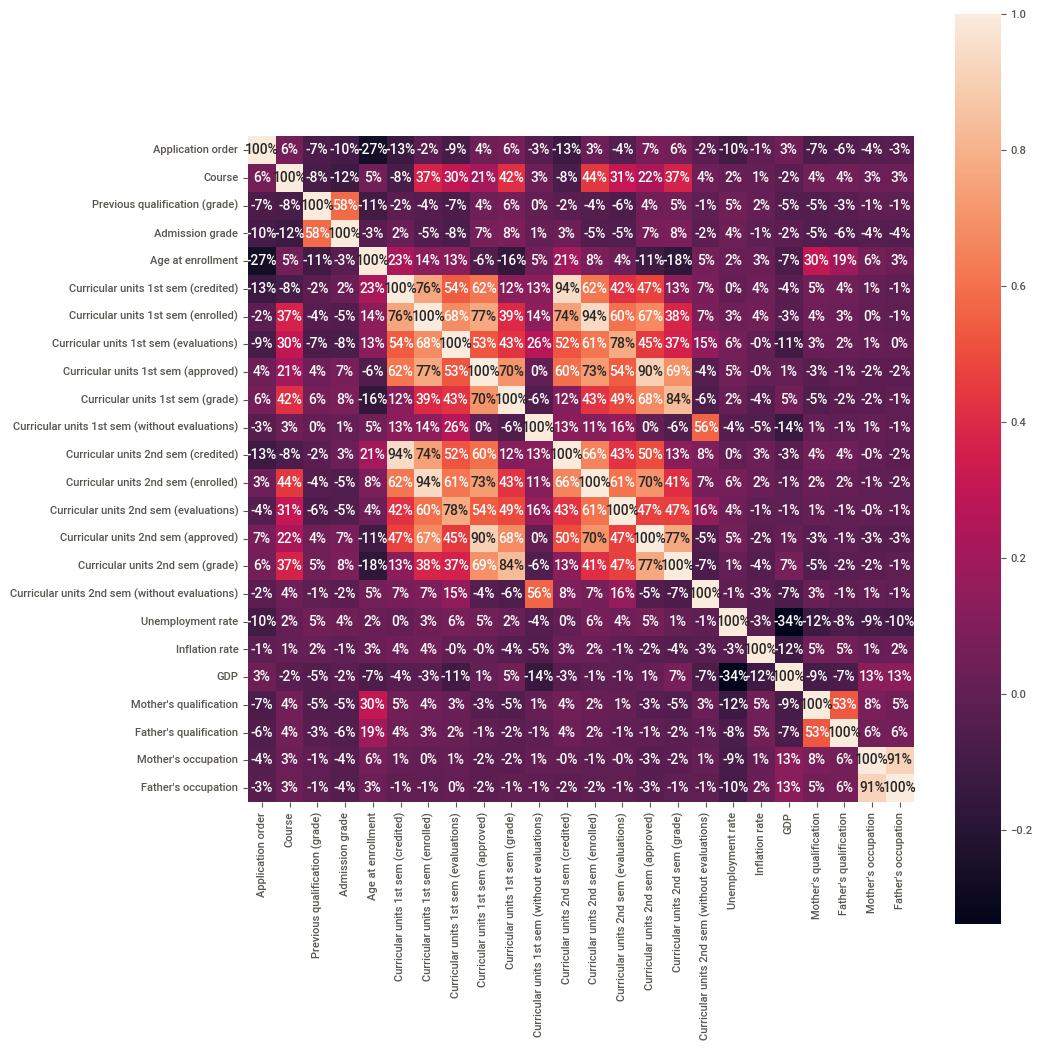

In [35]:
# quantitative associations
quantitative_df = eda_df[quantitative_vars]
corr = quantitative_df.corr()
plt.figure(figsize=(11,11))
sns.heatmap(corr, fmt='.0%', annot=True, square=True)
plt.tight_layout()

From the Pearson correlation, some variables appeared to be highly correlated. Let's check this collinearity with the VIF metric and that could possibly be an indication for feature selection.

The second metric for gauging multicollinearity is the variance inflation factor (VIF). The VIF directly measures the ratio of the variance of the entire model to the variance of a model with only the feature in question.

In layman’s terms, it gauges how much a feature’s inclusion contributes to the overall variance of the coefficients of the features in the model.

A VIF of 1 indicates that the feature has no correlation with any of the other features.

Typically, a VIF value exceeding 5 or 10 is deemed to be too high. Any feature with such VIF values is likely to be contributing to multicollinearity.

In [36]:
# Compute VIF data for each independent variable
clean_quantitative_df = quantitative_df.dropna()
vif = pd.DataFrame()
vif["features"] = clean_quantitative_df.columns
vif["vif_Factor"] = [variance_inflation_factor(clean_quantitative_df.values, i) for i in range(clean_quantitative_df.shape[1])]
vif.sort_values(by=['vif_Factor'], ascending=False, inplace=True)
vif

,features,vif_Factor
6,Curricular units 1st sem (enrolled),178.849117
12,Curricular units 2nd sem (enrolled),156.613317
2,Previous qualification (grade),123.313346
3,Admission grade,111.710452
1,Course,43.564668
8,Curricular units 1st sem (approved),42.623713
14,Curricular units 2nd sem (approved),32.907178
9,Curricular units 1st sem (grade),30.264086
15,Curricular units 2nd sem (grade),28.252250
17,Unemployment rate,21.885296


We see that a lot of variables have a high VIF and therefore, it may be variables to eliminate in the modeling that we will do later.

#### One qualitative and one quantitative variable

Here the idea is to check the correlation between the qualitative and quantitative variable (the target) to see if the qualitative variables have a high influence in the target.

To find this, we can use visualization methods, statistical measures, Anova or t-test.

In this case, one of the most commonly used hypothesis tests is the t-test, which is used to compare the means of two groups. The t-test is used to determine whether the difference between the means of two groups is statistically significant. Statistical significance refers to the likelihood that the difference between the means is not due to chance. If the difference is statistically significant, it means that there is a high probability that the difference is real and not just due to random variation.

This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In the specific case of this project, many of the distributions of quantitative variables do not follow a normal distribution, which is a premise of a t-test. In this case, an alternative to the t-test is the Mann-Whitney test, which is a non-parametric test that also compares the median between two groups and does not assume a specific data distribution.

The quantitative variable is: Application order
         min  max      mean       var       std
dropout                                        
0          0    9  1.800854  1.835665  1.354867
1          1    6  1.592905  1.463889  1.209913


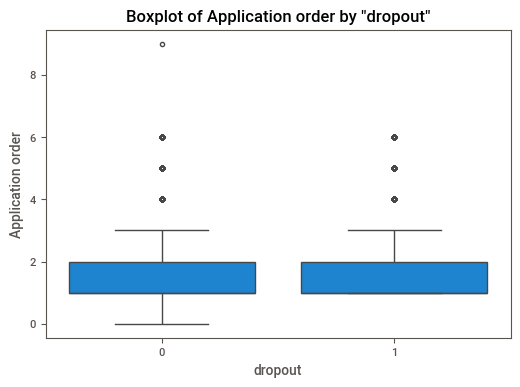

Mann-Whitney U test for Application order:
Statistic: 1392423.0
P-value: 2.2274216404588627e-07
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Course
         min   max         mean           var          std
dropout                                                   
0         33  9991  8891.339674  3.882200e+06  1970.329994
1         33  9991  8725.894426  5.446459e+06  2333.765026


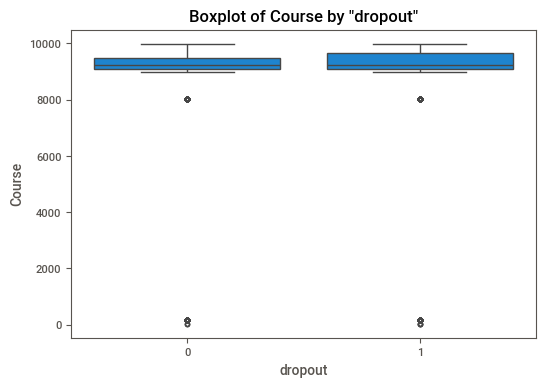

Mann-Whitney U test for Course:
Statistic: 1537188.5
P-value: 0.6920256516505641
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Previous qualification (grade)
          min    max        mean         var        std
dropout                                                
0        96.0  190.0  133.343905  176.591442  13.288771
1        95.0  190.0  131.192568  168.612776  12.985098


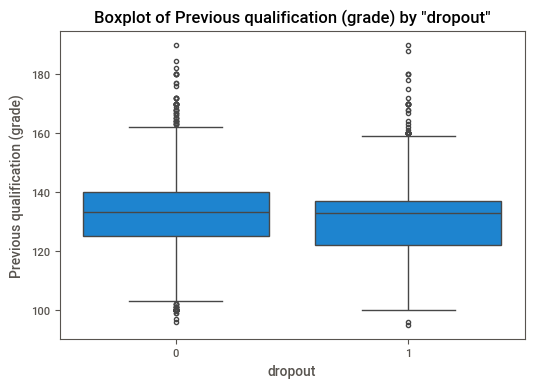

Mann-Whitney U test for Previous qualification (grade):
Statistic: 1368109.5
P-value: 3.7475743269316857e-07
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Admission grade
          min    max        mean         var        std
dropout                                                
0        95.0  190.0  127.861762  199.242425  14.115326
1        95.0  190.0  124.848902  229.368908  15.144930


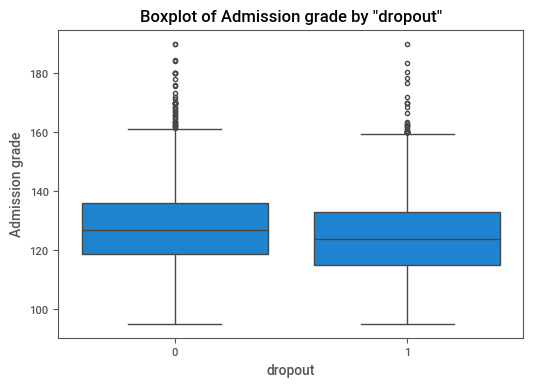

Mann-Whitney U test for Admission grade:
Statistic: 1339238.5
P-value: 1.8733960650429608e-09
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Age at enrollment
         min  max       mean        var       std
dropout                                          
0         17   62  21.901786  42.079282  6.486855
1         18   70  25.936655  73.083896  8.548912


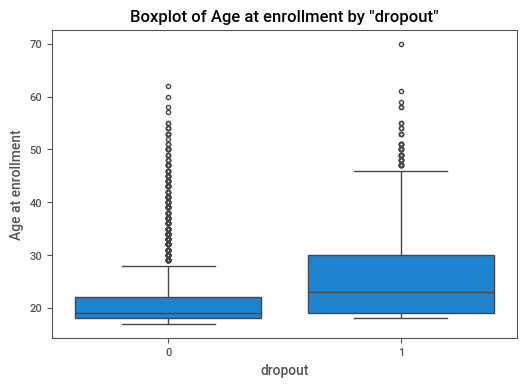

Mann-Whitney U test for Age at enrollment:
Statistic: 2043464.0
P-value: 1.1659873467918926e-64
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 1st sem (credited)
         min  max      mean       var       std
dropout                                        
0          0   20  0.721273  5.490437  2.343168
1          0   18  0.610642  4.496624  2.120524


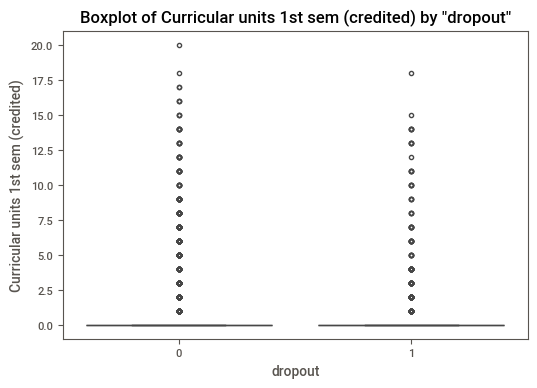

Mann-Whitney U test for Curricular units 1st sem (credited):
Statistic: 1512888.5
P-value: 0.5018638428180193
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 1st sem (enrolled)
         min  max      mean       var       std
dropout                                        
0          0   26  6.442158  6.085973  2.466977
1          0   21  5.756757  5.560394  2.358049


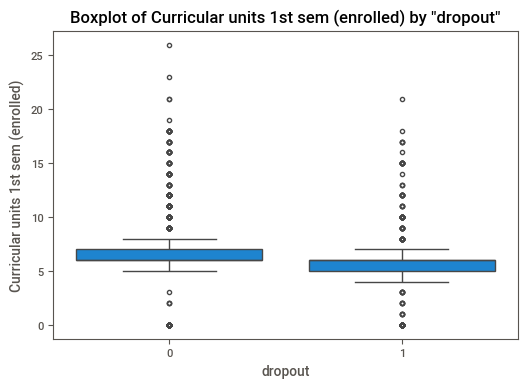

Mann-Whitney U test for Curricular units 1st sem (enrolled):
Statistic: 1178961.5
P-value: 5.20420520732643e-32
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 1st sem (evaluations)
         min  max      mean        var       std
dropout                                         
0          0   45  8.522516  14.169590  3.764252
1          0   31  7.641892  24.175961  4.916906


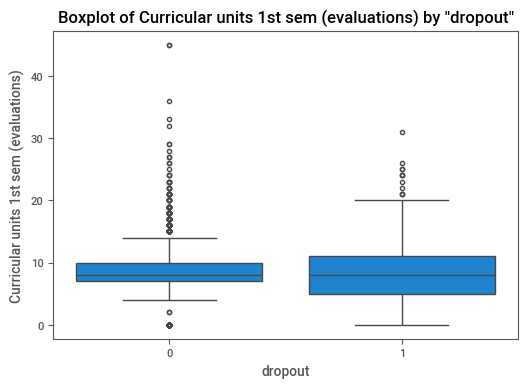

Mann-Whitney U test for Curricular units 1st sem (evaluations):
Statistic: 1408000.5
P-value: 0.00013798195316244285
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 1st sem (approved)
         min  max      mean       var       std
dropout                                        
0          0   26  5.697593  6.692592  2.587004
1          0   21  2.516047  8.123157  2.850115


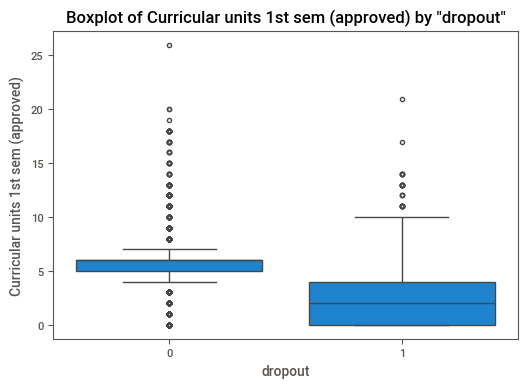

Mann-Whitney U test for Curricular units 1st sem (approved):
Statistic: 547390.5
P-value: 4.196374579542811e-226
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 1st sem (grade)
         min        max       mean        var       std
dropout                                                
0        0.0  18.875000  12.222622   9.465862  3.076664
1        0.0  17.333333   7.211596  36.314515  6.026153


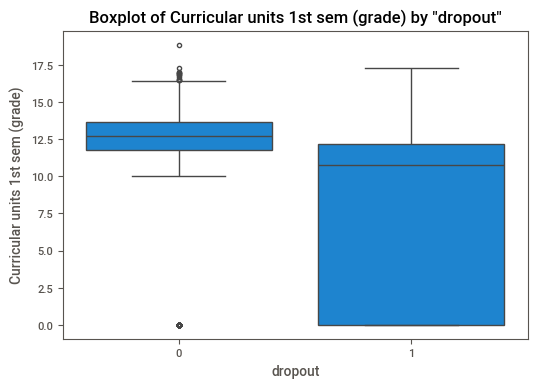

Mann-Whitney U test for Curricular units 1st sem (grade):
Statistic: 689743.5
P-value: 1.9288436416098556e-161
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 1st sem (without evaluations)
         min  max      mean       var       std
dropout                                        
0          0   12  0.109860  0.391421  0.625637
1          0    8  0.179054  0.584988  0.764845


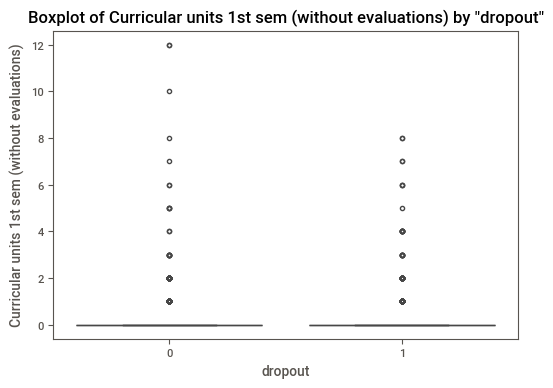

Mann-Whitney U test for Curricular units 1st sem (without evaluations):
Statistic: 1567168.5
P-value: 0.0013975201323416977
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 2nd sem (credited)
         min  max      mean       var       std
dropout                                        
0          0   18  0.557842  3.717818  1.928164
1          0   13  0.456081  2.899168  1.702694


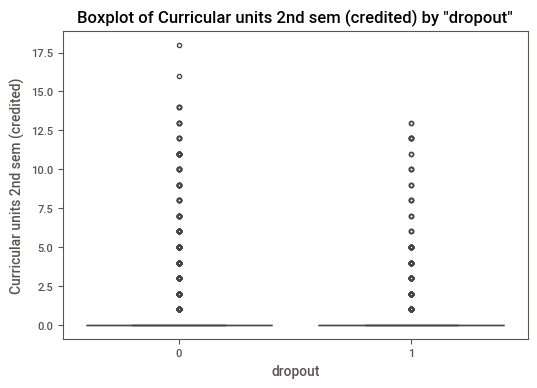

Mann-Whitney U test for Curricular units 2nd sem (credited):
Statistic: 1502130.0
P-value: 0.1865708993911629
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 2nd sem (enrolled)
         min  max      mean       var       std
dropout                                        
0          0   23  6.404115  4.648667  2.156077
1          0   18  5.717905  4.649011  2.156157


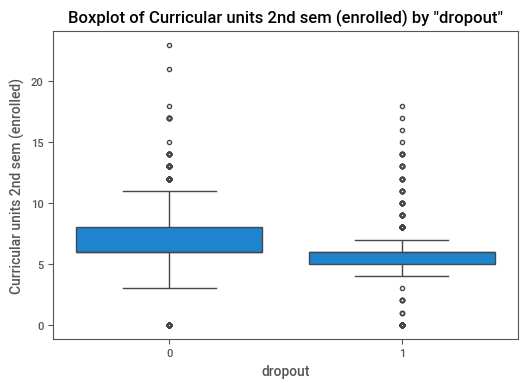

Mann-Whitney U test for Curricular units 2nd sem (enrolled):
Statistic: 1166279.5
P-value: 2.473594463434349e-34
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 2nd sem (evaluations)
         min  max      mean        var       std
dropout                                         
0          0   33  8.447593  11.386767  3.374428
1          0   25  7.060811  23.499257  4.847603


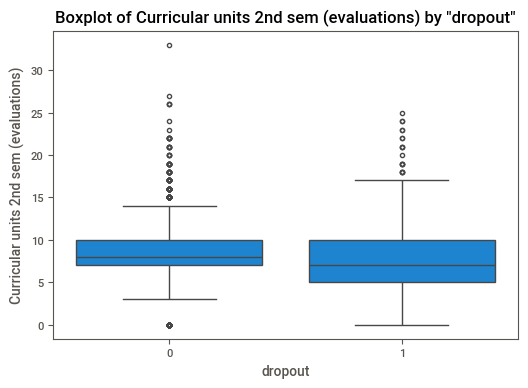

Mann-Whitney U test for Curricular units 2nd sem (evaluations):
Statistic: 1277372.5
P-value: 7.415755396711709e-16
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 2nd sem (approved)
         min  max      mean       var       std
dropout                                        
0          0   20  5.592003  5.680076  2.383291
1          0   16  1.904561  6.602042  2.569444


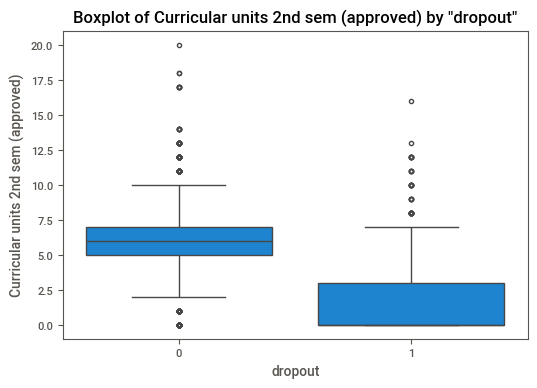

Mann-Whitney U test for Curricular units 2nd sem (approved):
Statistic: 437849.5
P-value: 1.1636950113994512e-277
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 2nd sem (grade)
         min        max       mean        var       std
dropout                                                
0        0.0  18.571429  12.265977   9.315647  3.052154
1        0.0  17.714286   5.788678  37.306958  6.107942


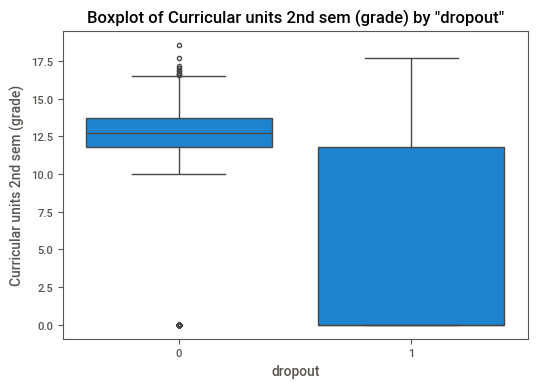

Mann-Whitney U test for Curricular units 2nd sem (grade):
Statistic: 552943.5
P-value: 1.157912568406254e-218
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Curricular units 2nd sem (without evaluations)
         min  max      mean       var       std
dropout                                        
0          0   12  0.107531  0.353093  0.594216
1          0   12  0.226351  0.951258  0.975324


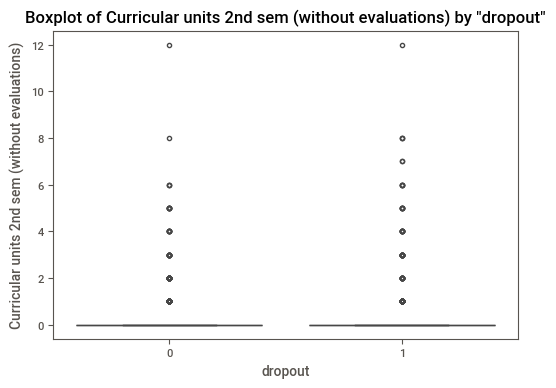

Mann-Whitney U test for Curricular units 2nd sem (without evaluations):
Statistic: 1567779.0
P-value: 0.0009045661032724984
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Unemployment rate
         min   max       mean       var       std
dropout                                          
0        7.6  16.2  11.569604  6.855748  2.618348
1        7.6  16.2  11.567568  7.535431  2.745074


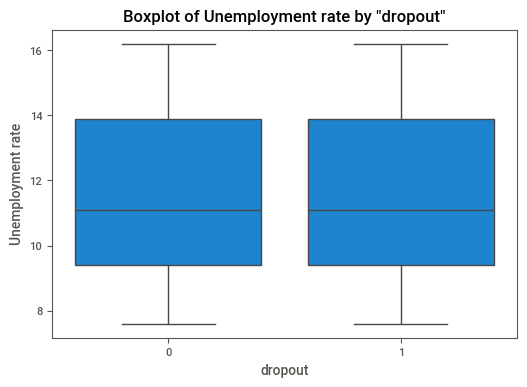

Mann-Whitney U test for Unemployment rate:
Statistic: 1519085.0
P-value: 0.8476814299853427
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Inflation rate
         min  max      mean       var       std
dropout                                        
0       -0.8  3.7  1.201825  1.873725  1.368841
1       -0.8  3.7  1.295355  1.965904  1.402107


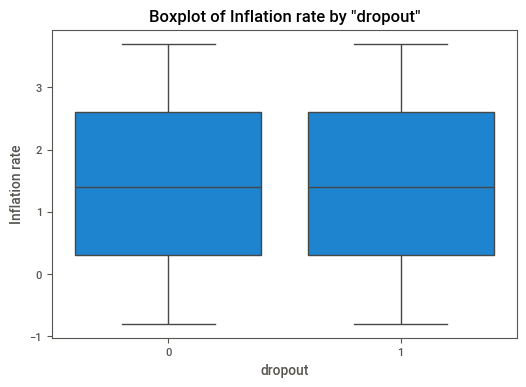

Mann-Whitney U test for Inflation rate:
Statistic: 1577747.5
P-value: 0.08523985816086799
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: GDP
          min   max      mean       var       std
dropout                                          
0       -4.06  3.51  0.072306  5.198034  2.279920
1       -4.06  3.51 -0.131351  5.084097  2.254794


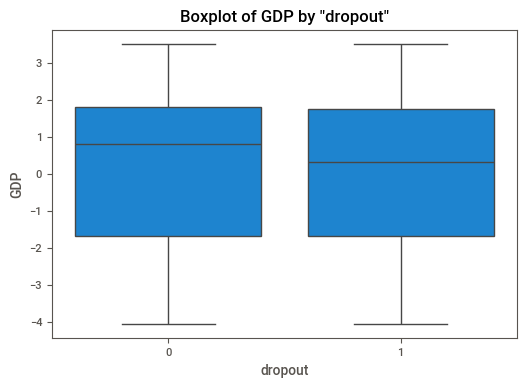

Mann-Whitney U test for GDP:
Statistic: 1426055.0
P-value: 0.0012936489075620235
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Mother's qualification
         min  max       mean         var        std
dropout                                            
0          1   43  18.634317  241.609913  15.543806
1          1   43  21.132601  239.734727  15.483369


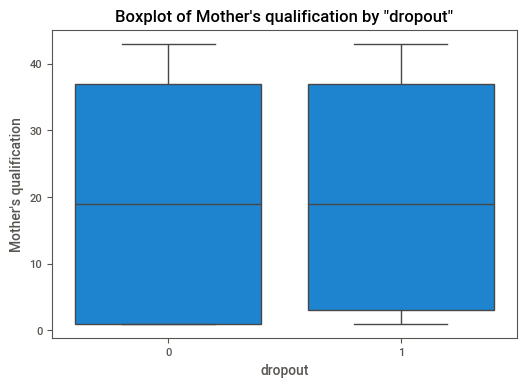

Mann-Whitney U test for Mother's qualification:
Statistic: 1617329.0
P-value: 0.0023132733574891154
There is a statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Father's qualification
         min  max       mean         var        std
dropout                                            
0          1   43  22.002329  235.584461  15.348761
1          1   44  23.055743  233.702723  15.287339


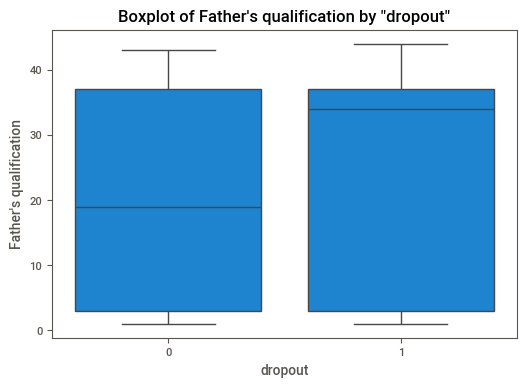

Mann-Whitney U test for Father's qualification:
Statistic: 1528177.5
P-value: 0.916116623177192
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Mother's occupation
         min  max       mean         var        std
dropout                                            
0          0  194  11.578804  869.620972  29.489337
1          0  194  10.204392  434.835619  20.852713


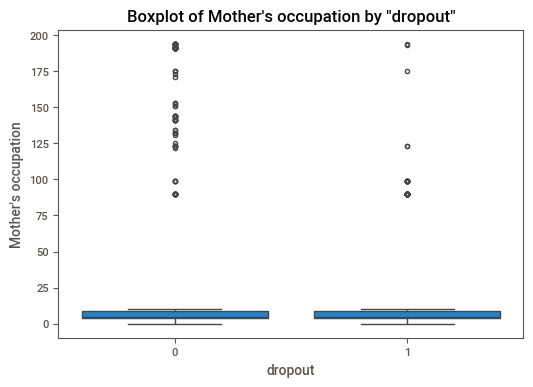

Mann-Whitney U test for Mother's occupation:
Statistic: 1469590.5
P-value: 0.06527854013132849
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------
The quantitative variable is: Father's occupation
         min  max       mean         var        std
dropout                                            
0          0  195  11.650621  781.919829  27.962829
1          0  194  10.279561  419.246378  20.475507


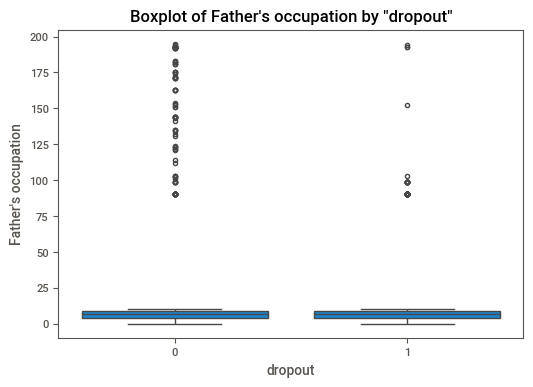

Mann-Whitney U test for Father's occupation:
Statistic: 1471456.0
P-value: 0.0804054538593525
There is no statistically significant difference in the medians.
------------------------------------------------------------------------------------------


In [37]:
# visualization and statistical measures approach
# Summary measures for quantitative independent features and label to search for relationships
for var in quantitative_vars:
    print('The quantitative variable is:', var)
    print(eda_df.groupby('dropout')[var].agg(['min', 'max', 'mean', 'var', 'std']))
    
    # Create a boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='dropout', y=var, data=eda_df)
    plt.title(f'Boxplot of {var} by "dropout"')
    plt.xlabel('dropout')
    plt.ylabel(var)
    plt.show()
    
    # Perform the Mann-Whitney U test
    group1 = eda_df[eda_df['dropout'] == 1][var]
    group2 = eda_df[eda_df['dropout'] == 0][var]
    statistic, p_value = stats.mannwhitneyu(group1, group2)
    
    # Print the results of the Mann-Whitney U test
    print(f'Mann-Whitney U test for {var}:')
    print(f'Statistic: {statistic}')
    print(f'P-value: {p_value}')
    
    if p_value < 0.05:  # Define an appropriate significance level
        print('There is a statistically significant difference in the medians.')
    else:
        print('There is no statistically significant difference in the medians.')
    
    print('------------------------------------------------------------------------------------------')

## Preprocessing

Based on what we have seen in exploratory data analysis, we gonna make some transformations in the data to be able to fit them in the linear regression model.

In [38]:
# select only the features that we are going to use
X = eda_df.drop(['dropout'], axis=1)
y = eda_df['dropout']

In [39]:
qualitative_preproc = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'))

quantitative_preproc = make_pipeline(
    StandardScaler())

preprocessor = ColumnTransformer([
    ('quantitative_preproc', quantitative_preproc, quantitative_features),
    ('qualitative_preproc', qualitative_preproc, qualitative_features_enconding)],
    remainder='passthrough')

## Logistic regression

The difference between this problem and linear regression is the fact that the response variable is dichotomous and not continuous. If we define the response variable y = 1 in the case of a positive response and y = 0 in the case of a negative response, the expected response will be equal to the probability p = E(y). As in the case of linear regression models, the objective of the analysis is to model the expected response, which in this case is a probability, as a function of the explanatory variable. For technical and interpretational reasons, instead of modeling this expected response, it is advisable to model a function of it, namely the logarithm of the chance of a positive response to avoid probability estimates with values ​​outside the range (0.1).

Once the logistic regression model estimated the probability P that an instance X belongs to the positive class, it can easily predict y:

* y_hat = 0 if P < 0,5
* y_hat = 1 if P >= 0,5

The training objective is to define the parameter vector β, so that the model estimates high probabilities for positive instances (y = 1) and low probabilities for negative instances (y = 0). The cost function embodies this idea.

Fit and evaluate a logistic regression model to predict dropout. 

Determine the accuracy of the model and its goodness of fit.

In [40]:
def run_classifier_models(X, y, cv, scoring):
    '''Function that trains the following machine learning models:
    RandomForestClassifier, DecisionTreeClassifier, SGDClassifier, SVC,
    LGBMClassifier, GaussianNB.
    The function applies cross-validation on the dataset and returns the average
    of the selected metric on the training and validation sets.
    The only active metrics are Accuracy and F1 score.
    Experiments with the models are logged with MLflow.
    
    :param X: (dataframe or numpy array) 
    Dataframe or array with the independent variables.
    
    :param y: (series or numpy array)
    Column or array with the dependent variable.
    
    :param cv: (int)
    Determines the cross-validation splitting strategy.
    
    :param scoring: (str)
    Strategy to evaluate the model's performance on the validation set during cross-validation.
    Should be passed within quotes when calling the function.
    '''
    # Instantiate the models
    logit = Pipeline(
        steps=[('preprocessor', preprocessor), 
               ('logit', LogisticRegression(random_state=42))]
    )
    scores = cross_validate(logit, X, y, return_train_score=True,
                            scoring=scoring, cv=cv, return_estimator=True)

    # train and validation with accuracy
    if scoring == 'accuracy':
        log_train_acc = np.mean(scores['train_score'])
        log_test_acc = np.mean(scores['test_score'])
        mean_train = log_train_acc.mean()
        mean_test = log_test_acc.mean()
        std_train = log_train_acc.std()
        std_test = log_test_acc.std()

    # train and validation with f1
    if scoring == 'f1':
        log_train_f1 = np.mean(scores['train_score'])
        log_test_f1 = np.mean(scores['test_score'])
        mean_train = log_train_f1.mean()
        mean_test = log_test_f1.mean()
        std_train = log_train_f1.std()
        std_test = log_test_f1.std()

    # Create final dataset
    df_result = pd.DataFrame(
        {'MODEL': logit[1], 'MEAN_TRAIN_SCORES': mean_train, 
         'MEAN_TEST_SCORES': mean_test, 'STD_TRAIN_SCORES': std_train, 
         'STD_TEST_SCORES': std_test}, index=[0])

    return df_result

In [41]:
# Run classifiers
df_result = run_classifier_models(X, y, 3, 'f1')
df_result

,MODEL,MEAN_TRAIN_SCORES,MEAN_TEST_SCORES,STD_TRAIN_SCORES,STD_TEST_SCORES
0,LogisticRegression(random_state=42),0.816393,0.792095,0.0,0.0


We have a bit of overfitting but the model seems to perform well.

## Hyperparameter tuning

In [42]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('logit', LogisticRegression(random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'logit__C': [0.01, 0.04, 0.1, 0.5, 1.0, 10.0],
} # you should try as many values as possible, but to illustrate we gonna put a heavy weight

# 3. Training and apply grid search with cross validation
grid_search = GridSearchCV(final_model, param_grid, cv = 5, scoring = 'f1',
                           return_train_score = True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'logit__C': 0.5}


In [43]:
cvres = grid_search.cv_results_
cvres = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres['mean_test_score'],
                                        cvres['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres[0])

The mean test score and mean train score is, respectively: (0.7930037138691086, 0.8113639346566635)


## Goodness of fit

Here, what we want to test is if our model is better than the baseline model (model's goodness of fit). The baseline model is if we predict the average (e.g. a probability of 0.6 for all instances).

To do this, we have to calculate the deviance of the model and the deviance of the baseline. To calculate the deviance, first we need to calculate the log-likelihood and then multiply the result to -2 (deviance = -2 x log-likelihood). This is the value of deviance.

The log-likelihood indicates how much information is left unexplained. Larger log-likelihood means poorer fit.

So, in the same way of log-likelihood, smaller deviance means a better fit.

The beauty of deviance is that it follows a chi-square distribuition and therefore we can test it. So what we are gonna test is if our model is better than the baseline model. So we're gonna obtain a chi-square statistic that is:

> X² = Deviance (baseline) - Deviance (model)

* If deviance is large -> model is poor
* Baseline -> suppose to have largest deviance
* If the model is good, its deviance is small -> X² is large 
* If the model is bad, its deviance is large -> X² is small
* Chi-squared tests the null hypothesis: The logistic regression is not better than the baseline
* Degrees of freedom: number of predictors

Large X² values and small p-values mean that the logistic regression is better than a baseline. Finally, with these informations we are able to calculate the R-statistic.

> R² = (Deviance (baseline) - Deviance (model)) / Deviance (baseline)

* If the model is as bad as the baseline -> R2 is close to 0
* If the model is good, its deviance is small -> R2 is closer to 1
* The smallest the deviance of the model, the greater the R2

In [44]:
# baseline model: mean of the target
base_preds = np.ones(len(y)) * y.mean()

# logit predictions
model_preds = grid_search.predict_proba(X)[:, 1]

# baseline log loss
base_logloss = log_loss(y, base_preds)

# model log loss
model_logloss = log_loss(y, model_preds)

# log-likelihood
def loglikelihood(y_true, y_pred):
    return - log_loss(y_true, y_pred, normalize=False)

# baseline log likelihood
base_likelihood = loglikelihood(y, base_preds)

# model log likelihood
model_likelihood = loglikelihood(y, model_preds)

# deviance
def deviance(y_true, y_pred):
    return 2 * log_loss(y_true, y_pred, normalize=False)

# baseline deviance
base_deviance = deviance(y, base_preds)

# model log likelihood
model_deviance = deviance(y, model_preds)

# chi-square
chi_square = base_deviance - model_deviance

# p-value
degrees_of_freedom = len(grid_search.best_estimator_.named_steps.preprocessor.get_feature_names_out())
p_value = stats.chi2.cdf(chi_square, degrees_of_freedom)
print('The p-value is:', p_value)

The p-value is: 1.0


Based on the result of p-value we failed to reject the null hyphotesis, so we conclude that our model is not better than a baseline.

In [45]:
# R-statistic
r = (base_deviance - model_deviance) / base_deviance
print('The R² is:', r)

The R² is: 0.5351816187738812


We obtain a relatively interesting R², we can try to improve it in later steps.

# Access the coefficients significance.

Now we want to determine if we can trust each one of the parameters of logistic regression model and the parameters are the coefficients. The interpretation of the β coefficient in logistic regression is slightly different of linear regression. A one unit increase in X_i will result in β (log odds) increase in the logarithmic success:failure ratio.

General equation: (B_0 + B_1 * X_1 + B_2 * X_2 + ... + B_n * X_n) > 0

* If B = 0, the feature does not affect the probability of the outcome
* If B > 0, the feature increases p(y=1)
* If B < 0, the feature decreases p(y=1)

We also want to test: Is B significantly different from 0? To do this, we gonna calculate the z-scores and p-values as well.

* Null hypothesis B = 0
* Alternative hypothesis B <> 0

In [46]:
# Function to fit the model with GridSearchCV and return the coefficients
def fit_model_and_get_coeffs(X_train, y_train, param_grid):
    grid_search_globally = GridSearchCV(final_model, param_grid, cv=5, scoring='f1', return_train_score=True)
    grid_search_globally.fit(X_train, y_train)
    return grid_search_globally.best_estimator_.named_steps.logit.coef_, grid_search_globally.best_estimator_.named_steps.preprocessor.get_feature_names_out()

# Number of Bootstrap iterations
num_bootstrap_iterations = 100

# List to store coefficients for each Bootstrap iteration
coeffs_bootstrap = []

# Initialize list of coefficient names
coeffs_names = []

# Loop over each Bootstrap iteration
for i in range(num_bootstrap_iterations):
    # Random sampling with replacement of indices
    indices = np.random.choice(range(len(X)), size=len(X), replace=True)
    X_bootstrap, y_bootstrap = X.iloc[indices], y.iloc[indices]

    # Split the sampled dataset into train and test
    X_train, X_val, y_train, y_val = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2, random_state=42)
    
    # Fit the model and obtain coefficients for this sample
    coeffs_boot, new_coeffs_names = fit_model_and_get_coeffs(X_train, y_train, param_grid)
    
    # Add unique coefficient names
    coeffs_names.extend([name for name in new_coeffs_names if name not in coeffs_names])
    
    # Add coefficients of this Bootstrap iteration to the list
    coeffs_boot = np.array(coeffs_boot)[0]
    coeffs_bootstrap.append(coeffs_boot)
    
# Determine the maximum length of coefficients array
max_coeffs_length = max(len(coeffs) for coeffs in coeffs_bootstrap)

# Fill coefficients arrays with zeros so that they all have the same length
coeffs_bootstrap_padded = [np.pad(coeffs, (0, max_coeffs_length - len(coeffs)), mode='constant') for coeffs in coeffs_bootstrap]

# Convert the list of coefficients arrays into a numpy matrix
coeffs_bootstrap = np.vstack(coeffs_bootstrap_padded)

# Ensure coeffs_names has the same length as the number of columns in coeffs_mean
coeffs_names = coeffs_names[:coeffs_bootstrap.shape[1]]

# Calculate the mean of coefficients
coeffs_mean = np.mean(coeffs_bootstrap, axis=0)

# Calculate the standard deviation of coefficients
coeffs_std = np.std(coeffs_bootstrap, axis=0)

# Create a DataFrame to store the mean and standard deviation of coefficients
coeffs_df = pd.DataFrame({'mean_coeffs_sign': coeffs_mean, 'coeffs_std': coeffs_std}, index=coeffs_names).reset_index()
coeffs_df.sort_values(by=['mean_coeffs_sign'], ascending=False, inplace=True)
coeffs_df.rename(columns={'index': 'features'}, inplace=True)

# Visualize the DataFrame
coeffs_df

,features,mean_coeffs_sign,coeffs_std
12,quantitative_preproc__Curricular units 2nd sem...,1.064702,0.267773
39,qualitative_preproc__Application mode_27,0.849063,0.794516
38,qualitative_preproc__Application mode_26,0.728552,0.548128
40,qualitative_preproc__Application mode_39,0.572304,0.689704
66,qualitative_preproc__Previous qualification_3,0.560946,0.763567
...,...,...,...
43,qualitative_preproc__Application mode_44,-0.563256,0.564151
44,qualitative_preproc__Application mode_51,-0.640428,0.713522
28,qualitative_preproc__Marital Status_5,-0.667471,0.774450
8,quantitative_preproc__Curricular units 1st sem...,-1.007107,0.236221


In [47]:
# calculate z and the p-values
coeffs_df['z'] = coeffs_df['mean_coeffs_sign'] / coeffs_df['coeffs_std']
coeffs_df['p_values'] = stats.norm.sf(abs(coeffs_df['z']))*2  # two sided
coeffs_df

,features,mean_coeffs_sign,coeffs_std,z,p_values
12,quantitative_preproc__Curricular units 2nd sem...,1.064702,0.267773,3.976132,7.004513e-05
39,qualitative_preproc__Application mode_27,0.849063,0.794516,1.068655,2.852252e-01
38,qualitative_preproc__Application mode_26,0.728552,0.548128,1.329164,1.837938e-01
40,qualitative_preproc__Application mode_39,0.572304,0.689704,0.829782,4.066618e-01
66,qualitative_preproc__Previous qualification_3,0.560946,0.763567,0.734639,4.625593e-01
...,...,...,...,...,...
43,qualitative_preproc__Application mode_44,-0.563256,0.564151,-0.998415,3.180783e-01
44,qualitative_preproc__Application mode_51,-0.640428,0.713522,-0.897559,3.694207e-01
28,qualitative_preproc__Marital Status_5,-0.667471,0.774450,-0.861864,3.887623e-01
8,quantitative_preproc__Curricular units 1st sem...,-1.007107,0.236221,-4.263406,2.013346e-05


In [48]:
coeffs_df.loc[(coeffs_df['p_values'] < 0.05)]

,features,mean_coeffs_sign,coeffs_std,z,p_values
12,quantitative_preproc__Curricular units 2nd sem...,1.064702,0.267773,3.976132,7.004513e-05
11,quantitative_preproc__Curricular units 2nd sem...,0.477025,0.179410,2.658861,7.840534e-03
1,quantitative_preproc__Course,0.279263,0.133216,2.096306,3.605502e-02
4,quantitative_preproc__Age at enrollment,0.250884,0.097338,2.577460,9.952948e-03
17,quantitative_preproc__Unemployment rate,0.223528,0.076798,2.910601,3.607339e-03
15,quantitative_preproc__Curricular units 2nd sem...,-0.372333,0.162494,-2.291361,2.194254e-02
8,quantitative_preproc__Curricular units 1st sem...,-1.007107,0.236221,-4.263406,2.013346e-05
14,quantitative_preproc__Curricular units 2nd sem...,-1.953568,0.188100,-10.385778,2.878138e-25


As we can see, we have a lot of coefficients that is not significantly different from 0. In the next steps, maybe we can test a new model without these variables and maybe make a simple model and obtain the same (or better) results.

## Re-train the logistic regression 

Based on the exploratory analysis and the significance of the trained model's coefficients, we will select only the most important variables to analyze the results and create a simpler and easier model to interpret.

In [49]:
class DropVariables(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_delete):
        self.columns_to_delete = columns_to_delete

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.columns_to_delete, axis=1)
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        return [feat for feat in input_features if feat not in self.columns_to_delete]

In [50]:
qualitative_binary_passthrough = [
    'Tuition fees up to date'
]

# select quantitative features
quantitative_features = [
    'Application order',
    'Age at enrollment',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'GDP'
]

features_to_drop = [
    'Marital Status', 'Application mode',
    'Course', 'Previous qualification',
    'Nacionality', 'Daytime/evening attendance',
    'Displaced', 'Educational special needs',
    'Gender', 'Scholarship holder', 'Debtor',
    'Course', 'Curricular units 1st sem (credited)',
    'Curricular units 2nd sem (credited)',
    'Unemployment rate', 'Inflation rate',
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Curricular units 1st sem (enrolled)',
    'Previous qualification (grade)',
    'Admission grade',
    'Curricular units 1st sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 1st sem (approved)',
    "Mother's qualification"
]

drop_features_preproc = make_pipeline(
    DropVariables(features_to_drop))

quantitative_preproc = make_pipeline(
    StandardScaler())

preprocessor2 = ColumnTransformer([
    ('quantitative_preproc', quantitative_preproc, quantitative_features),
    ('features_to_drop', drop_features_preproc, features_to_drop)],
    remainder='passthrough')

In [51]:
quantitative_df2 = eda_df[quantitative_features]

# Compute VIF data for each independent variable
clean_quantitative_df = quantitative_df2.dropna()
vif = pd.DataFrame()
vif["features"] = clean_quantitative_df.columns
vif["vif_Factor"] = [variance_inflation_factor(clean_quantitative_df.values, i) for i in range(clean_quantitative_df.shape[1])]
vif.sort_values(by=['vif_Factor'], ascending=False, inplace=True)
vif

,features,vif_Factor
4,Curricular units 2nd sem (enrolled),22.091946
5,Curricular units 2nd sem (approved),12.732334
6,Curricular units 2nd sem (grade),11.078491
2,Curricular units 1st sem (evaluations),9.194772
1,Age at enrollment,7.078859
0,Application order,2.511071
3,Curricular units 1st sem (without evaluations),1.163548
7,GDP,1.044332


In [52]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model2 = Pipeline(
    steps=[
        ('preprocessor2', preprocessor2), 
        ('logit2', LogisticRegression(random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'logit2__C': [0.01, 0.04, 0.1, 0.5, 1.0, 10.0],
} # you should try as many values as possible, but to illustrate we gonna put a heavy weight

# 3. Training and apply grid search with cross validation
grid_search2 = GridSearchCV(final_model2, param_grid, cv = 5, scoring = 'f1',
                           return_train_score = True)
grid_search2.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search2.best_params_)

The best hyperparameters were: {'logit2__C': 10.0}


In [53]:
cvres2 = grid_search2.cv_results_
cvres2 = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres2['mean_test_score'],
                                        cvres2['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres2[0])

The mean test score and mean train score is, respectively: (0.7734852176148833, 0.7753634332976691)


As we can see, performance on the validation dataset did not drop much and our variables decreased drastically. We created practically the same model, but much simpler besides the overfitting that no longer exists.

## Odds ratio, sign and magnitude of coefficients - globally

In [54]:
# Function to fit the model with GridSearchCV and return the coefficients
def fit_model_and_get_coeffs(X_train, y_train, param_grid):
    grid_search_globally = GridSearchCV(final_model2, param_grid, cv=5, scoring='f1', return_train_score=True)
    grid_search_globally.fit(X_train, y_train)
    return grid_search_globally.best_estimator_.named_steps.logit2.coef_, grid_search_globally.best_estimator_.named_steps.preprocessor2.get_feature_names_out()

# Number of Bootstrap iterations
num_bootstrap_iterations = 100

# List to store coefficients for each Bootstrap iteration
coeffs_bootstrap = []

# Initialize list of coefficient names
coeffs_names = []

# Loop over each Bootstrap iteration
for i in range(num_bootstrap_iterations):
    # Random sampling with replacement of indices
    indices = np.random.choice(range(len(X)), size=len(X), replace=True)
    X_bootstrap, y_bootstrap = X.iloc[indices], y.iloc[indices]

    # Split the sampled dataset into train and test
    X_train, X_val, y_train, y_val = train_test_split(X_bootstrap, y_bootstrap, test_size=0.2, random_state=42)
    
    # Fit the model and obtain coefficients for this sample
    coeffs_boot, new_coeffs_names = fit_model_and_get_coeffs(X_train, y_train, param_grid)
    
    # Add unique coefficient names
    coeffs_names.extend([name for name in new_coeffs_names if name not in coeffs_names])
    
    # Add coefficients of this Bootstrap iteration to the list
    coeffs_boot = np.array(coeffs_boot)[0]
    coeffs_bootstrap.append(coeffs_boot)
    
# Determine the maximum length of coefficients array
max_coeffs_length = max(len(coeffs) for coeffs in coeffs_bootstrap)

# Fill coefficients arrays with zeros so that they all have the same length
coeffs_bootstrap_padded = [np.pad(coeffs, (0, max_coeffs_length - len(coeffs)), mode='constant') for coeffs in coeffs_bootstrap]

# Convert the list of coefficients arrays into a numpy matrix
coeffs_bootstrap = np.vstack(coeffs_bootstrap_padded)

# Ensure coeffs_names has the same length as the number of columns in coeffs_mean
coeffs_names = coeffs_names[:coeffs_bootstrap.shape[1]]

# Calculate the mean of coefficients
coeffs_mean = np.mean(coeffs_bootstrap, axis=0)

# Calculate the standard deviation of coefficients
coeffs_std = np.std(coeffs_bootstrap, axis=0)

# Create a DataFrame to store the mean and standard deviation of coefficients
coeffs_df = pd.DataFrame({'mean_coeffs_sign': coeffs_mean, 'coeffs_std': coeffs_std}, index=coeffs_names).reset_index()
coeffs_df.sort_values(by=['mean_coeffs_sign'], ascending=False, inplace=True)
coeffs_df.rename(columns={'index': 'features'}, inplace=True)

# Visualize the DataFrame
coeffs_df['odds_ratio'] = np.exp(coeffs_df['mean_coeffs_sign'].values)
coeffs_df['absolute_coeffs'] = np.abs(coeffs_df['mean_coeffs_sign'].values)

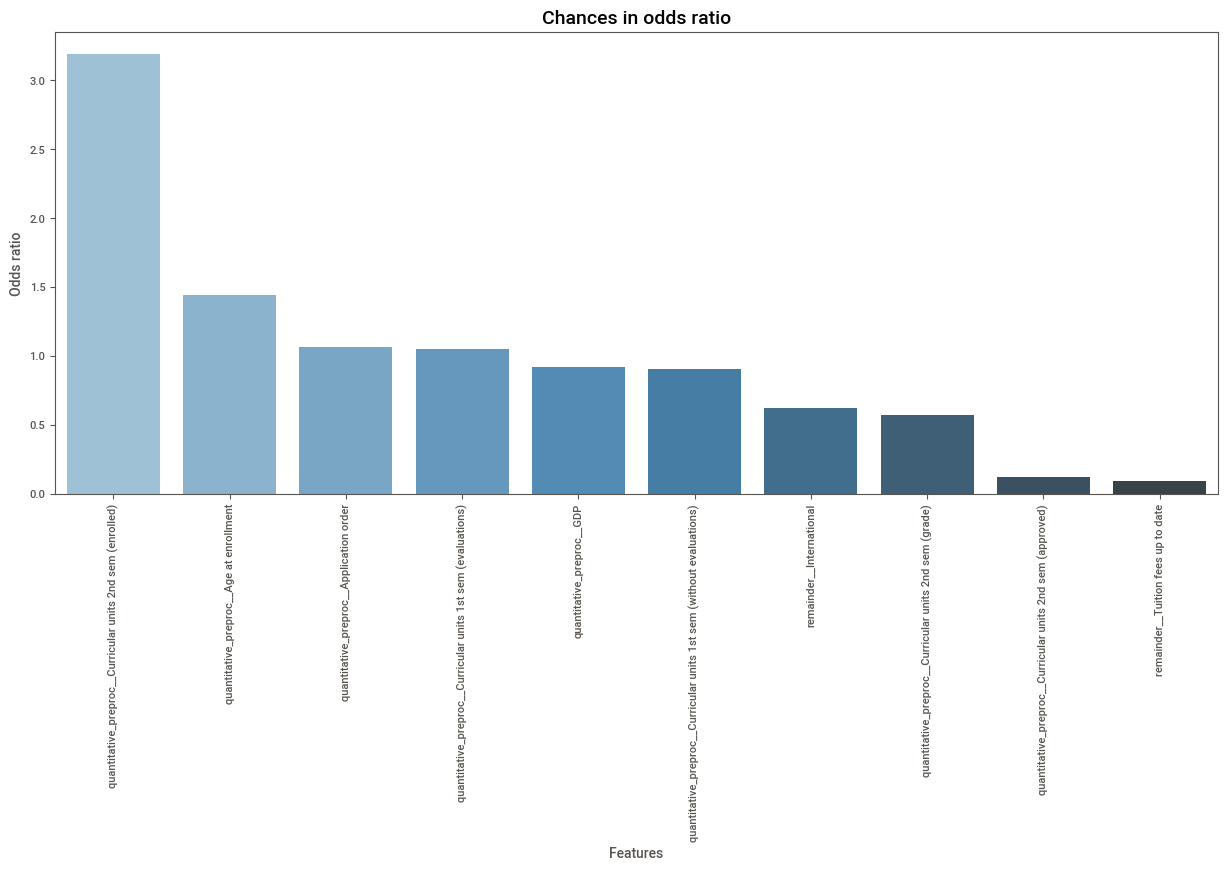

In [55]:
# Create a function of the graph to reuse later
def barplot(figsize, title, data, x, y, xlabel, ylabel, error_data=None):
    # Plot the graph
    plt.figure(figsize=figsize)

    # Title
    plt.title(title, fontsize=14)

    # Graph
    sns.barplot(data=data, x=x, y=y, ci=None, palette="Blues_d")

    # Adding error bars if error_data is provided
    if error_data is not None:
        std_err = error_data
        plt.errorbar(data[x], data[y], yerr=std_err, fmt='none', color='k', capsize=5)

    # Label
    plt.xticks(rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Example usage:
barplot((15, 6), 'Chances in odds ratio', coeffs_df,
        'features', 'odds_ratio', 'Features', 'Odds ratio')

* The feature "Curricular units 2nd sem (enrolled)", increase the probability of dropout almost 3 times.
* The feature "Age at enrollment", increase the probability of dropout almost 1,5 times.

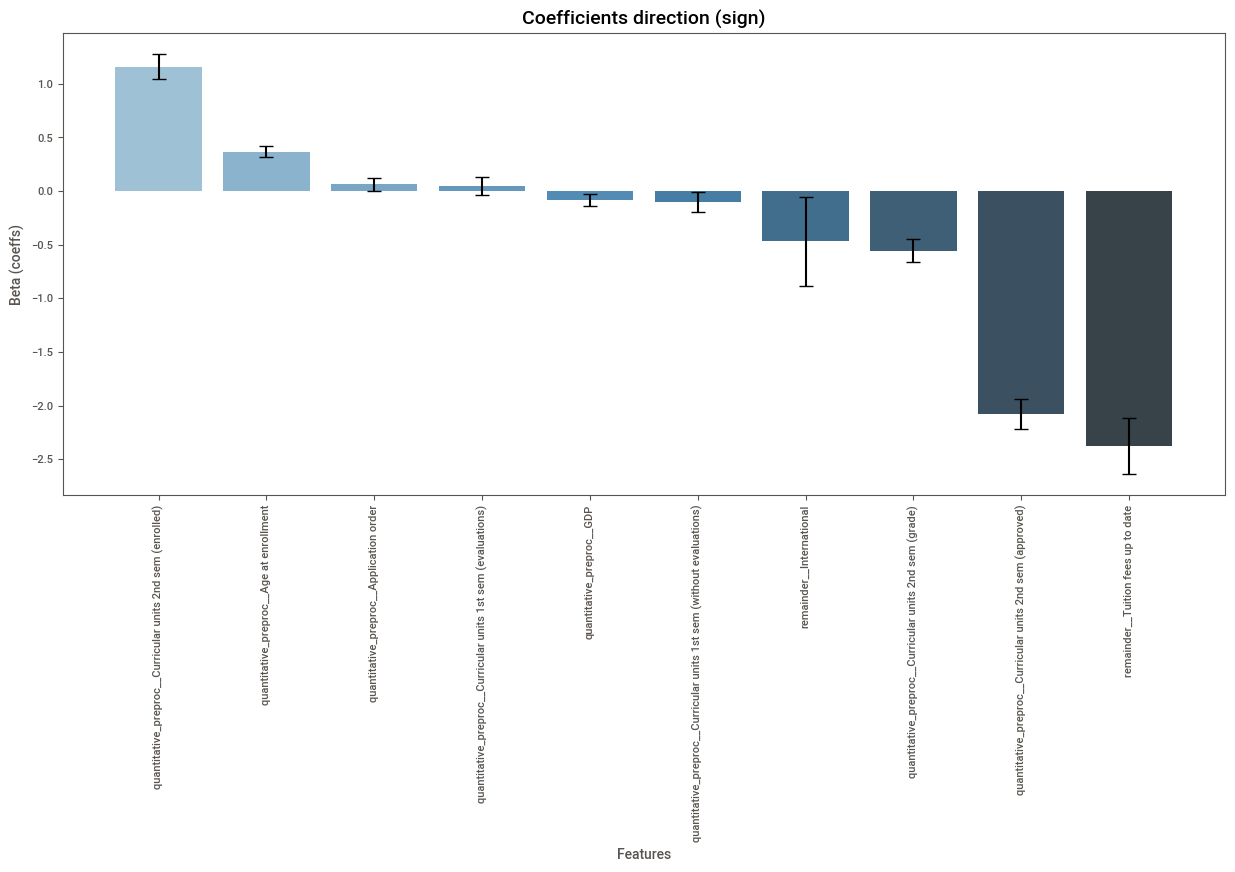

In [56]:
barplot((15, 6), 'Coefficients direction (sign)', coeffs_df,
        'features', 'mean_coeffs_sign', 'Features', 'Beta (coeffs)',
        error_data=coeffs_df['coeffs_std'])

By looking at the coefficient sign we conclude that an increase of one unit in the variable "Curricular units 2nd sem (enrolled)" results in Beta increase in the probability of a given person leaving the course.

Similarly, if a person is up to date with their tuition fees, this results in a Beta decrease in the probability of a given person leaving the course.

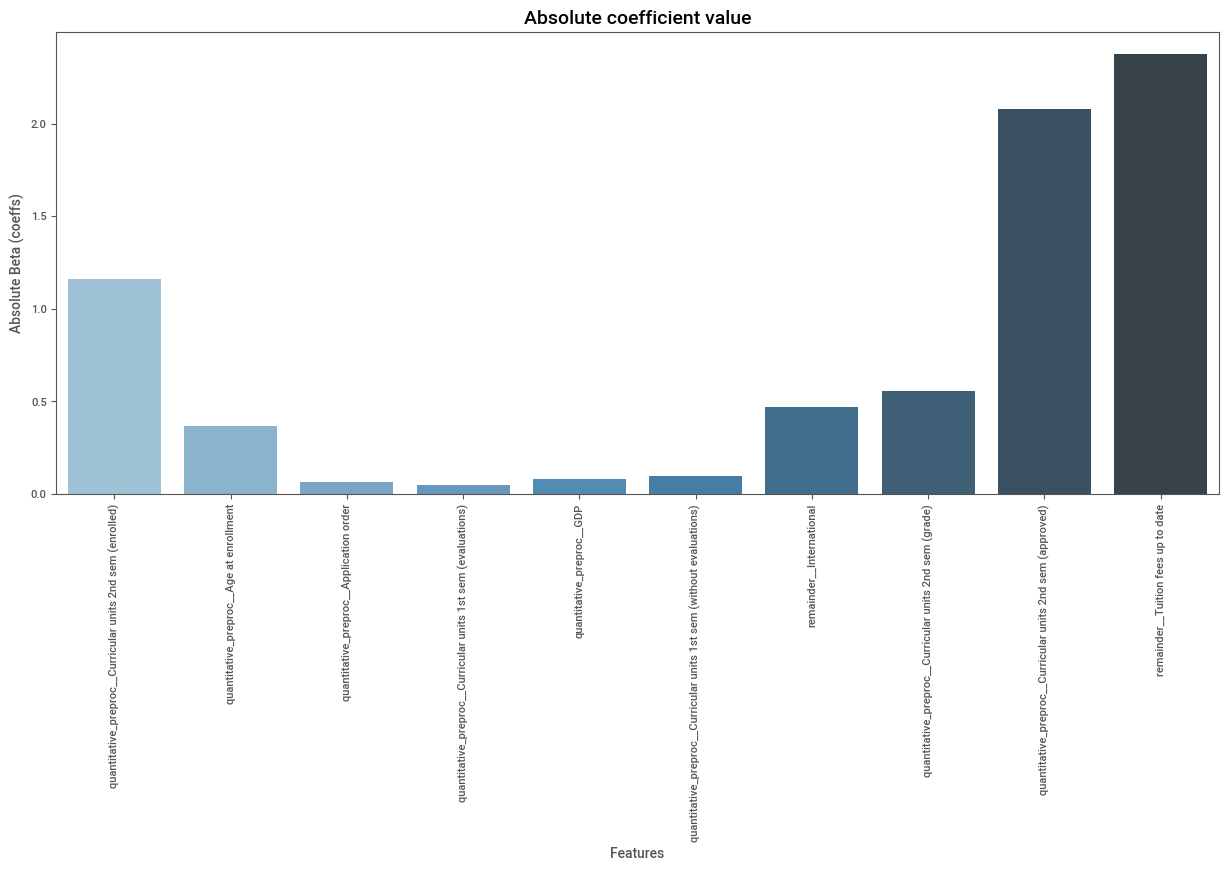

In [57]:
barplot((15, 6), 'Absolute coefficient value', coeffs_df,
        'features', 'absolute_coeffs', 'Features', 'Absolute Beta (coeffs)')

Here we see the magnitude of the coefficients in absolute value, which is often used for variable selection, determining which variables are most important for the model.

## Local explanations

The same interpretation that we did globally (for all instances) we can also do locally for just one instance if you are interested in a specific case.

In [58]:
# organize the test set
test_set['dropout'] = np.where(test_set['Target'] == 'Dropout', 1, 0)
test_set.drop(columns=['Target'], inplace=True)

# select only the features that we are going to use
X_test = test_set.drop(['dropout'], axis=1)
y_test = test_set['dropout']

In [59]:
# get the coefficients and the values of the variables
scaler_names = grid_search2.best_estimator_.named_steps.preprocessor2.get_feature_names_out()
final_coeffs = grid_search2.best_estimator_.named_steps.logit2.coef_
# X_test_transformed = grid_search2.best_estimator_.named_steps['preprocessor2'].transform(X_test)

In [60]:
# calculate the predictions for instance 1545
pred = grid_search2.best_estimator_.predict(X_test.loc[[1545]])
print('The prediction for this instance is:', pred)

pred_proba = grid_search2.best_estimator_.predict_proba(X_test.loc[[1545]])
print('The probabilities for this instance is:', pred_proba)

print('The real value of the target for this instance is:', y_test.loc[1545])

The prediction for this instance is: [0]
The probabilities for this instance is: [[0.95657332 0.04342668]]
The real value of the target for this instance is: 0


As we can see, the model was correct in predicting that this respective student will not leave the course.

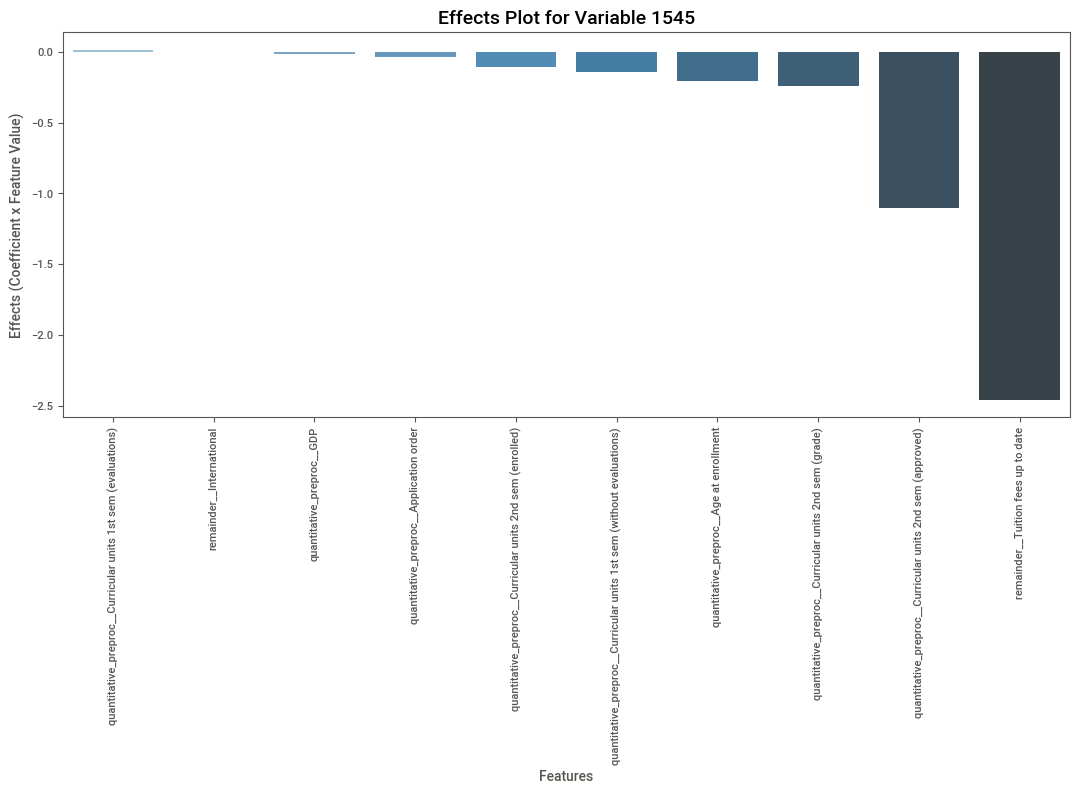

In [61]:
# calculate the effects of instance 1545
effects = (final_coeffs * grid_search2.best_estimator_.named_steps['preprocessor2'].transform(X_test.loc[[1545]])).flatten()

# create the dataframe for the instance 1000
effects_df = pd.DataFrame({'coeffs_sign': effects}, index=scaler_names).reset_index()
effects_df.sort_values(by=['coeffs_sign'], ascending=False, inplace=True)
effects_df.rename(columns={'index': 'features'}, inplace=True)

# plot the bar graph
barplot((13, 5), 'Effects Plot for Variable 1545', effects_df, 
        'features', 'coeffs_sign', 
        'Features', 'Effects (Coefficient x Feature Value)')

The same interpretation that we did globally, we can do locally in a specific instance that is of interest to you.

## Conclusion

Here I want to summarize somethings of the logistic regression models. Logistic regression makes some assumptions about the data, not as many as linear regression, but a few.

* Linearity: there is a linear relantionship between any continuous feature and the log(odds) of the variable.
* Independence: all values of the target are independent (each row in the dataset is independent).

Multicolinearity is not an assumption as in linear regression, but it can still affect the coefficients of the regression. We want to remove highly collinear input features.

Logistic regression is also sensitive to some characteristics of the data. For example, it has to be possible to separate the classes linearly by 1 or a combination of variables, you also have to take care about unbalanced classes of the features and the target.

Lasso can reduce the number of features by shrinking their coefficients to zero.

Credits:

https://www.trainindata.com/